# Why Bother?

Whenever you work with applied data science, even if you don't know it, you have to answers causal questions. For example, let's suppose you work at a big bank. If you work in credit lines, you will have to figure out how does changing the customer line changes you'r revenue. Or if you work at the local government, you might be asked to figure out how to make the schooling system better. Should you give tablets to every kid because the era of digital knowledge tells you to? Or should you build an old fashioned library? Or you work for a marketing agency, or a human resources one, or in retail... Wherever you are, will will have to answer questions like "how much extra customers does this marketing campaign is brings us?", "is this employee training program increasing productivity?" or "how much extra revenue, if any, will we get by increasing the price of this merchandise?".

Although it might not seem at first, these sort of questions are not solvable by traditional machine learning. If you think about it, all machine learning does is make super good predictions, but you don't have a prediction problem here. Sure, with ML you could build a very cool model to predict which schools from your city will perform better in some standard anual test. You could even add to you model features telling if the school has a library or if it allow kids to use tablets in class. But all you will ever be able to answer is which one of them will do good or bad on the test. Note that this is not the interesting question. Instead, what would be useful to know is **if we give tablets to a school, will it be better off?**

Answering this kind of question is tougher than most people appreciate. Your parents have probably repeated to your ears that "association is not causation", "association is not causation". But actually explaining why that is a little bit more involving. This is what this introduction to causal inference is about. The rest of is dedicated to **figuring how to make association be causation**.


Intuitively, we kind of know why association is not causation. If someone tells you that schools that give tablets to its students perform better than those who don't, you can quickly point out that it is probably that case that those schools with the tablets are richer. As such, they would do better than average even without the tablets. Because of this, we can't conclude that giving tablets to kids during classes will cause an increase their academic performance. We can only say that tablets in school are associated with high academic performance.

In [13]:
import pandas as pd
import numpy as np
from scipy.special import expit
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

style.use("fivethirtyeight")

np.random.seed(123)
n = 100
tuition = np.random.normal(1000, 300, n).round()
tablet = np.random.binomial(1, expit((tuition - tuition.mean()) / tuition.std())).astype(bool)
enem_score = np.random.normal(200 - 50 * tablet + 0.7 * tuition, 200)
enem_score = (enem_score - enem_score.min()) / enem_score.max()
enem_score *= 1000

data = pd.DataFrame(dict(enem_score=enem_score, Tuition=tuition, Tablet=tablet))

In /Users/matheus.facure/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/matheus.facure/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/matheus.facure/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/matheus.facure/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/matheus.facure/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 

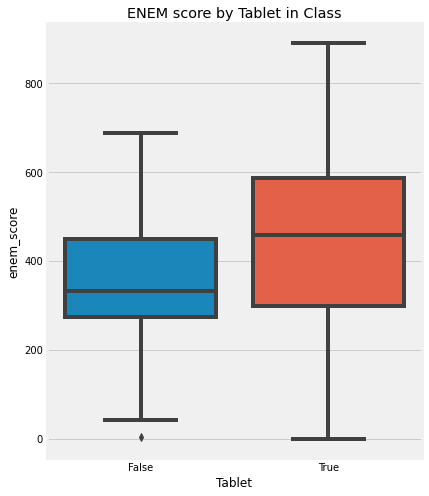

In [14]:
plt.figure(figsize=(6,8))
sns.boxplot(y="enem_score", x="Tablet", data=data).set_title('ENEM score by Tablet in Class')
plt.show()

# Potential Outcome Notation

To get pass beyond simple intuition, let's first establish some notation. This will be our common language to speak about causality. Let's call \\(T_i\\) the treatment intake for unit i. 

$
T_i=\begin{cases}
1 \ \text{if unit i received the treatment}\\
0 \ \text{otherwise}\\
\end{cases}
$

Let's call \\(Y_i\\) the observed outcome variable for unit i.

$
Y_i
$

Now is where things gets interesting. The **fundamental problem of causal inference** is that we can never observe the same unit with and without treatment. It is as if we have two diverging roads and we can only know what lies ahead of the one we take. As in Robert Frost poem:

```
Two roads diverged in a yellow wood,
And sorry I could not travel both
And be one traveler, long I stood
And looked down one as far as I could
To where it bent in the undergrowth;
```

To wrap around this, we will talk a lot in term of **potential outcomes**. They are potential because they did't actually happened. Instead they mean what would have happened in the case some treatment was taken. We sometimes call the potential outcome that happened, factual, and the one that didn't happened, counterfactual. As for the notation, we use an additional subscript:

\\(Y_{0i}\\) is the potential outcome for unit i without the treatment.

\\(Y_{1i}\\) is the potential outcome for unit i with the treatment.


With potential outcomes, we can define the indivitual treatment effect:

 \\(Y_{1i} - Y_{0i}\\)
 
Of course, due to the fundamental problem of causal inference, we can never know the indivitual treatment effect because we only observe one of the potential outcomes. For the time, lets focus on something easier than estimating the individual treatment effect. Instead, lets focus on the **average treatment effect**, which is defined as follows.

\\(ATE = E[Y_1 - Y_0]\\)

Another easier quantity to estimate is the **average treatment effect on the treated**:

\\(ATET = E[Y_1 - Y_0 | T=1]\\)

Now, I know we can't see both botetial outcome, but just for the sake of better understanding, let's supose we could. And say we collected data on 4 schools, on whether they give tablets to its students and their score on some anual test. Here, tablets is the treatment, so \\(T=1\\) will be one the schools gives tablets to its kids. \\(Y\\) will be the test score.

In [15]:
pd.DataFrame(dict(
    i= [1,2,3,4],
    y0=[500,600,800,700],
    y1=[450,600,600,750],
    t= [0,0,1,1],
    y= [500,600,600,750],
    te=[-50,0,-200,50],
))

,i,y0,y1,t,y,te
0,1,500,450,0,500,-50
1,2,600,600,0,600,0
2,3,800,600,1,600,-200
3,4,700,750,1,750,50


The \\(ATE\\) here would be the mean of the last column, that is, of the treatment effect:

\\(ATE=(-50 + 0 - 200 + 50)/4 = -50\\)

The \\(ATET\\) here would be the mean of the last column when \\(T=1\\):

\\(ATET=(- 200 + 50)/2 = -75\\)

Now, of corse we can never know this. In reality, the table above would look like this:

In [16]:
pd.DataFrame(dict(
    i= [1,2,3,4],
    y0=[500,600,np.nan,np.nan],
    y1=[np.nan,np.nan,600,750],
    t= [0,0,1,1],
    y= [500,600,600,750],
    te=[np.nan,np.nan,np.nan,np.nan],
))

,i,y0,y1,t,y,te
0,1,500.0,NaN,0,500,NaN
1,2,600.0,NaN,0,600,NaN
2,3,NaN,600.0,1,600,NaN
3,4,NaN,750.0,1,750,NaN


What I like about this table is that it gives a nice intuition of what causal inference is about. We already know it is about finding the causal effect, but now we can see that this is essentially a missing variable problem. If we could somehow impute the missing values in the table above, we would be able to find the causal effect. We will see how to dot hat latter For now, let's revisit our data about the effect of tablets in the classroom.

# Bias

Bias is what makes association different from causation. Fortunately, it too is easy to understand intuitively. Let's recap our tablets in the classroom example. When confronted with the claim that schools with that give tablets to its kids go better on tests score, we can rebut it by saying those schools will probably do better anyway, even without the tables. That is because they probably have more money than the other schools, and hence can pay better teachers, afford better classroom, and so on. In other words, it is the case that treated schools (with tablets) are not comparable with untreated schools before the treatment. 

To say this in potential outcome notation is to say that \\(Y_0\\) of the treated is different than the \\(Y_0\\) of the untreated. Note how the \\(Y_0\\) of the treated **is counterfactual**. We can't observe it, but we can reason about it. In this particular case, we can even leverage our understanding of how the world works to go even further. We can say that, probably, \\(Y_0\\) of the treated is bigger than \\(Y_0\\) of the untreated schools. That is because schools that can afford to give tablets to its kids can afford other factors that can contribute to better test score. Let this sink in for a moment. It takes some time to get used to talking about potential outcome. Read this paragraph again and make sure you understand it.

With this in mind, we can show with very simple math why is it the case that association is not causation. Association is measured by \\(E[Y|T=1] - E[Y|T=0]\\). In our example, this is the average test score for the schools with tablets minus the average test score for those without it. On the other hand, causation is measured by \\(E[Y_1 - Y_0]\\).

To see how they relate, let's take the association measurement and replace the observed outcomes with the potential outcomes. For the treated, the observed outcome is \\(Y_1\\). For the untreated, the observed outcome is \\(Y_0\\).

$
E[Y|T=1] - E[Y|T=0] = E[Y_1|T=1] - E[Y_0|T=0]
$

Now, let's add and subtract \\(E[Y_0|T=1]\\). This is a counterfactual outcome. It tells what would have been the outcome of the treated have they not received the treatment.

$
E[Y|T=1] - E[Y|T=0] = E[Y_1|T=1] - E[Y_0|T=0] + E[Y_0|T=1] - E[Y_0|T=1]
$

Finally, we reorder the terms, merge some expectations, and lo and behold:

$
E[Y|T=1] - E[Y|T=0] = \underbrace{E[Y_1 - Y_0|T=1]}_{ATET} + \underbrace{\{ E[Y_0|T=0] - E[Y_0|T=1] \}}_{BIAS}
$

This simple piece of math encompass all of causality. I cannot stress how important it is that you understand every aspect of it. Let's break it down into some of its implications. First, it tell why association is not causation. As we can see, association is equal to the treatment effect on the treated plus a bias term. **The bias is given by how the treated and control group differ before the treatment, that is, in case neither of them has received the treatment**. We can now say precisely why do we are suspicious when someone tells us that tablets in the classroom boost academic performance. We think that, is this example, \\(E[Y_0|T=0] < E[Y_0|T=1]\\), that is, schools that can afford to give tablets to its kids are better than those that can't regardless of the tablets. For instance, we can think of a third variable, like tuition, that explain both the treatment assignment, that is, the presence of tablets, and also explains the performance in the test score. If that is the case, then for us to say that tablets in the classroom increase academic performance, we would need for schools with and without them to have, on average, the same tuition cost in order to be comparable.

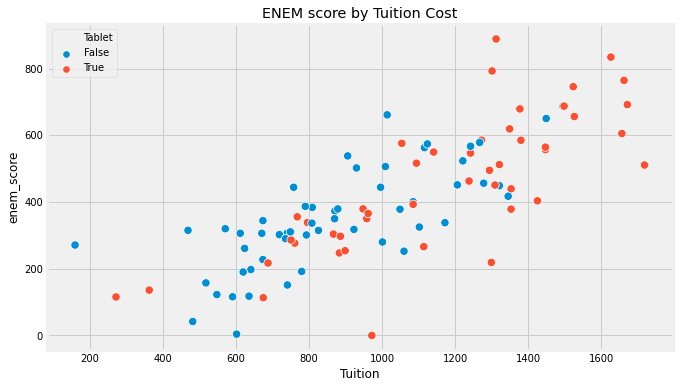

In [17]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="Tuition", y="enem_score", hue="Tablet", data=data, s=70).set_title('ENEM score by Tuition Cost')
plt.show()

We can also say what would be necessary to make association equal to causation. **If \\(E[Y_0|T=0] = E[Y_0|T=1]\\), then, association IS CAUSATION!** Understanding this is not just remembering the equation. There is a strong intuitive argument here. To say that \\(E[Y_0|T=0] = E[Y_0|T=1]\\) is to say that treatment and control group are comparable before the treatment. Or, in the cause that the treated had not been treated, if we could observe its \\(Y_0\\), then, its outcome would be the same as the untreated. Mathematically, the bias term would vanish.

$
E[Y|T=1] - E[Y|T=0] = E[Y_1 - Y_0|T=1]
$

Also, if the treated and the untreated only differ on the treatment itself, that is,  \\(E[Y_0|T=0] = E[Y_0|T=1]\\)

$
E[Y_1 - Y_0|T=1] = E[Y_1|T=1] - E[Y_1|T=0] = E[Y_1|T=1] - E[Y_0|T=0] = E[Y|T=1] - E[Y|T=0]
$

Hence, in this case, the diference in mean IS the causal effect:

$
E[Y|T=1] - E[Y|T=0] = ATE = ATET
$

# Key Ideas

So far, we've seen that association is not causation. Most importantly, we've seen precisely why it isn't and how can we make association be causation. We've also introduced the potential outcome notation as a way to wrap our head about causal reasoning. With it, we see statistics as two potential realities: one in which the treatment is given and another in which it is not. But, unfortunately, we can only mesure one of them, and that is where the fundamental problem of causal inference lies.

Moving forward, we will see some of the basic techniques to estimate causal effect, starting with the golden standard of a randomised trial. I'll also review some statistical concepts as we go. I'll end with a quote often used in causal inference classes, taken from a kung-fu series:

```
'What happens in a man's life is already written. A man must move through life as his destiny wills.' -Caine
'Yes, yet each man is free to live as he chooses. Though they seem opposite, both are true.' -Old Man
```

## References

I like to think of this entire series is a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this though year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

My final reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)